# Problem statement

Most customers do not post a review rating or any comment after purchasing a product which is a challenge for any ecommerce platform to perform If a company predicts whether a customer liked/disliked a product so that they can recommend more similar and related products as well as they can decide whether or not a product should be sold at their end.
This is crucial for ecommerce based company because they need to keep track of each product of each seller , so that none of products discourage their customers to come shop with them again. Moreover, if a specific product has very few rating and that too negetive, a company must not drop the product straight away, may be many customers who found the product to be useful haven't actually rated it.

Some reasons could possibly be comparing your product review with those of your competitors beforehand,gaining lots of insight about the product and saving a lot of manual data pre-processin,maintain good customer relationship with company,lend gifts, offers and deals if the company feels the customer is going to break the relation.

Objective of this case study is centered around predicting customer satisfaction with a product which can be deduced after predicting the product rating a user would rate after he makes a purchase.

# Constraints

High Accuracy 

Low latency (Rating should be known within the completion of the order)

Prone to outliers


**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Loading Data**

In [2]:
cust_data = pd.read_csv('../input/brazilian-ecommerce/olist_customers_dataset.csv')
geo_data =  pd.read_csv('../input/brazilian-ecommerce/olist_geolocation_dataset.csv')
order_items =  pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
order_payments =  pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
order_reviews =  pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
order_data =  pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
products_data = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')
sellers_data = pd.read_csv('../input/brazilian-ecommerce/olist_sellers_dataset.csv')
product_category = pd.read_csv('../input/brazilian-ecommerce/product_category_name_translation.csv')

# Understanding the data

**Customer data - contains information about the customer**

In [3]:
cust_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
cust_data.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

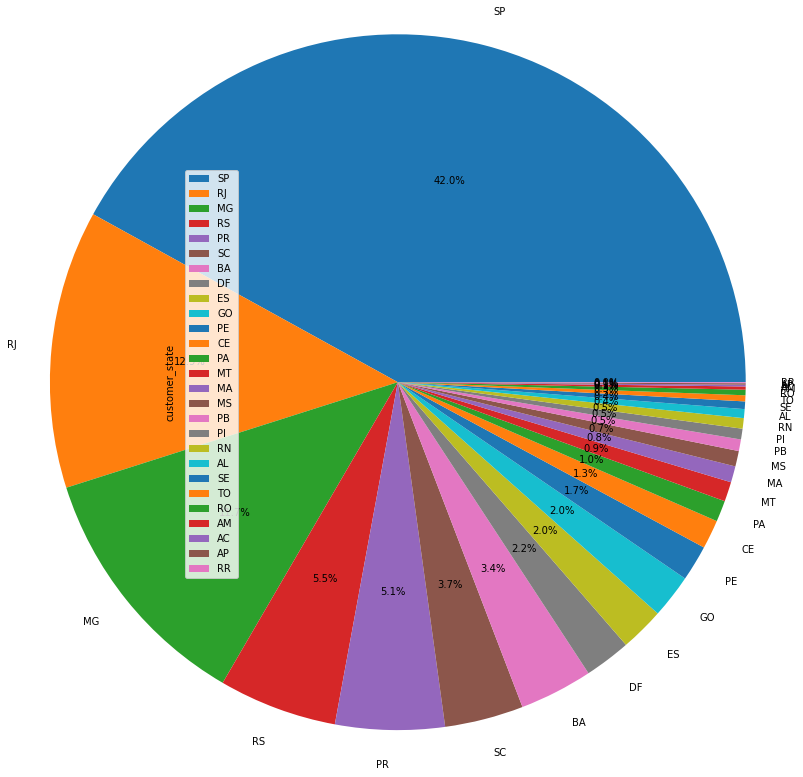

In [5]:
cust_data.customer_state.value_counts().plot(kind='pie',figsize=(10,8),autopct='%.1f%%',radius=2)
plt.legend()
plt.show()

In [6]:
#Top 10 cities with their value counts
cust_data.customer_city.value_counts().sort_values(ascending=False)[:10]

sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_city, dtype: int64

**Order_item Data ( each item in a particular order )**

In [7]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
#checking if any null/NA present in any entry
order_items.isnull().any().any()

False

In [9]:
print('Number of sellers :',order_items.seller_id.unique().shape[0])
print('Number of unique products are : ',order_items.product_id.unique().shape[0])

Number of sellers : 3095
Number of unique products are :  32951


**Price feature**

In [10]:
order_items.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

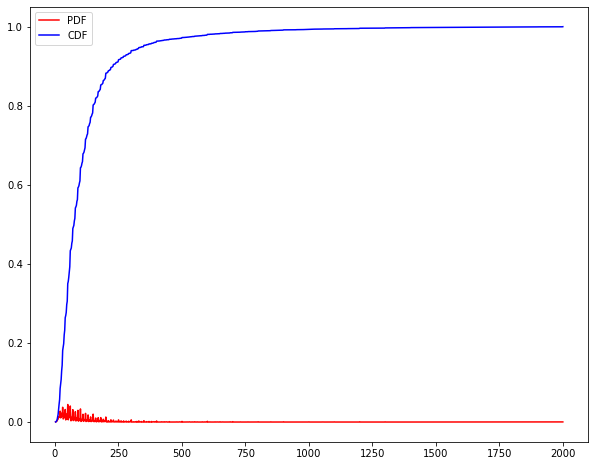

In [11]:
#temporararily removing few outliers that can reduce the smoothness of the pdf and cdf
sata = order_items[order_items.price <= 2000]
counts, bin_edges = np.histogram(sata.price, bins=1000, 
                                 density = True)
pdf = counts/(sum(counts))

#compute CDF
cdf = np.cumsum(pdf)
plt.figure(figsize=(10,8))
plt.plot(bin_edges[1:],pdf,color='red',label='PDF')
plt.plot(bin_edges[1:], cdf,color='blue',label='CDF')
plt.legend()


plt.show();

**Observation**

1. Price is centered around 40-120 Brazilian real, so the box plot is not able separate any of the review score based on the price as hue. 

2. User rating is infact not depended soley on the price of the product.

**Order_Payments**

In [12]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


**Payment method Feature**

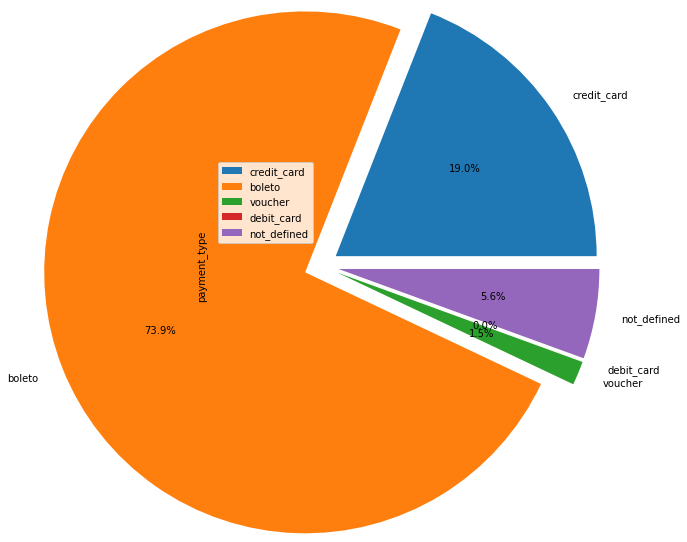

In [13]:
#Most used Payment method for orders
explode = [0.2]*5
order_payments['payment_type'].groupby(order_payments['payment_type']).count().plot(kind='pie',radius=3,labels=order_payments.payment_type.unique(),autopct='%.1f%%',explode=explode)
plt.legend()
plt.show()

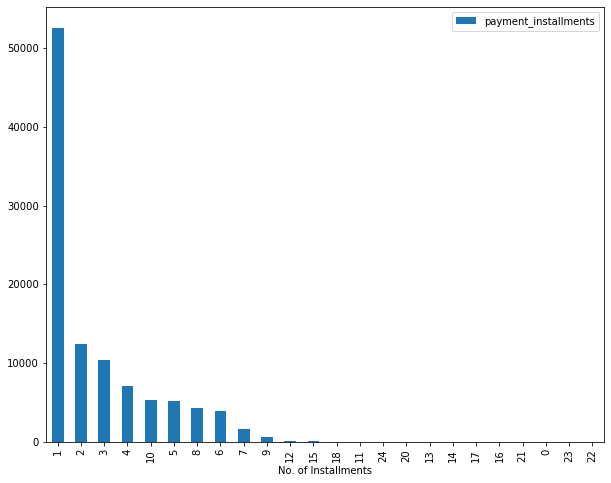

In [14]:
#number of installments feature
order_payments.payment_installments.value_counts().plot(kind = 'bar',figsize=(10,8))
plt.legend()
plt.xlabel('No. of Installments')
plt.show()

In [15]:
#checking if any null/NA present in any entry
order_payments.isnull().any().any()

False

**Observation**

1. Most customers have made the payment through vouchers i.e 73.8% and then credit card about 19.5%.
2. Number of installments majority of the time is 1, that is full payment was done. Otherwise it is not more than
    4 in most of the cases.

**Order_reviews data**

In [16]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


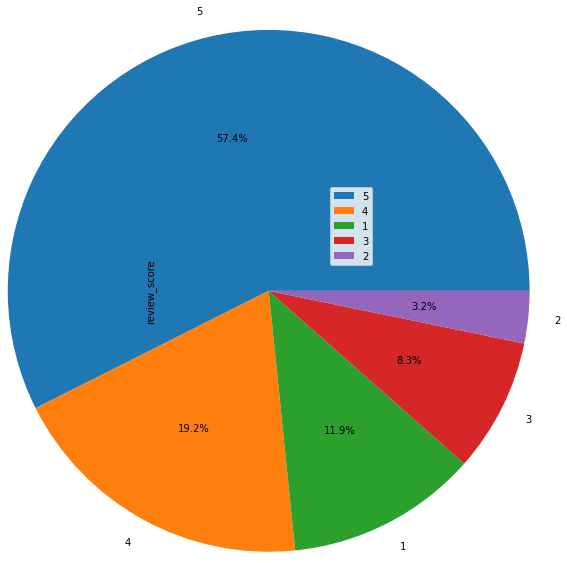

In [17]:
#pie chart for review_score
order_reviews.review_score.value_counts().plot(kind = 'pie',radius=3,autopct='%.1f%%')
plt.legend()
plt.show()

In [18]:
#how many null/missing entries are present
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

**Observations**

* Review_score by maximum customers is 5 star(57%) and 4star(19.2%)

*  review_comment_title and review_comment_message have lots of entires as blank or null, which is a problem. This is however xpected because most customers don't prefer to write reviews.
    
*  As the percentage of null/blank value is over 30% (here it is about 80%) , so we drop these two features.

**Orders_data**

In [19]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


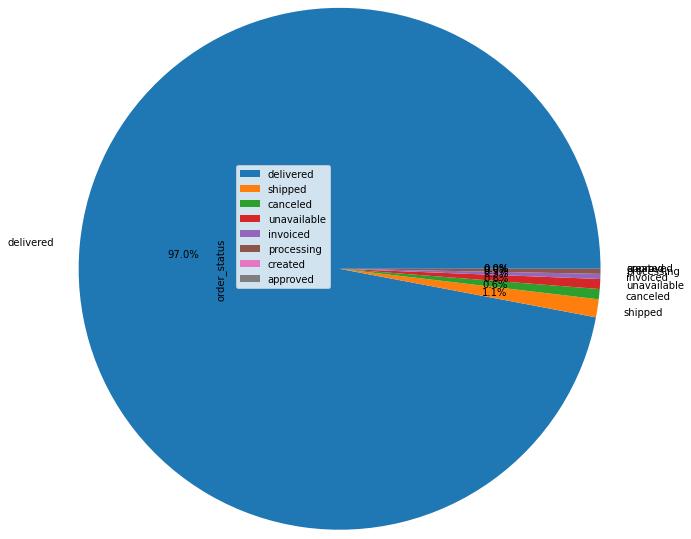

In [20]:
#order_status
order_data.order_status.value_counts().plot(kind='pie',radius=3,autopct='%.1f%%')
plt.legend()
plt.show()

In [21]:
#checking if any null/NA present in any entry
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**Observations**

1. Almost 97.77% of orders are marked as delivered, some values are canceled, approved e.t.c. Note that such circumstances are very rare which shows in the data too, so this feature is of no use. We can drop it.

2. There are some orders which have missing order_delivered_carrier_date, order_delivered_customer_date and very few have order_approved_at missing.


**Products Data**

In [22]:
products_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [23]:
products_data.rename(columns = {'product_name_lenght':'product_name_length',
                       'product_description_lenght':'product_description_length'},inplace=True)

Text(0.5, 0, 'product_description_length')

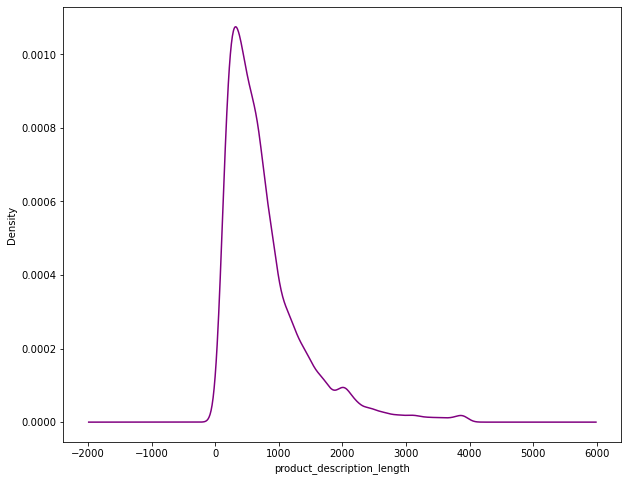

In [24]:
#Density plot of product_description_length and 
products_data.product_description_length.plot(kind='density',figsize=(10,8),color= 'purple')
plt.xlabel('product_description_length')

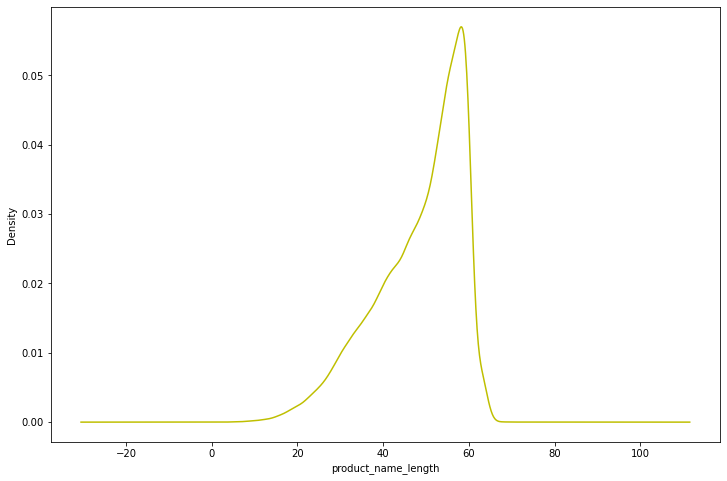

In [25]:
#Density plot of product_description_length
d = products_data.product_name_length

d.plot(kind='kde',figsize=(12,8),color= 'y')
plt.xlabel('product_name_length')
plt.show()

**PDF and CDF for product description length**

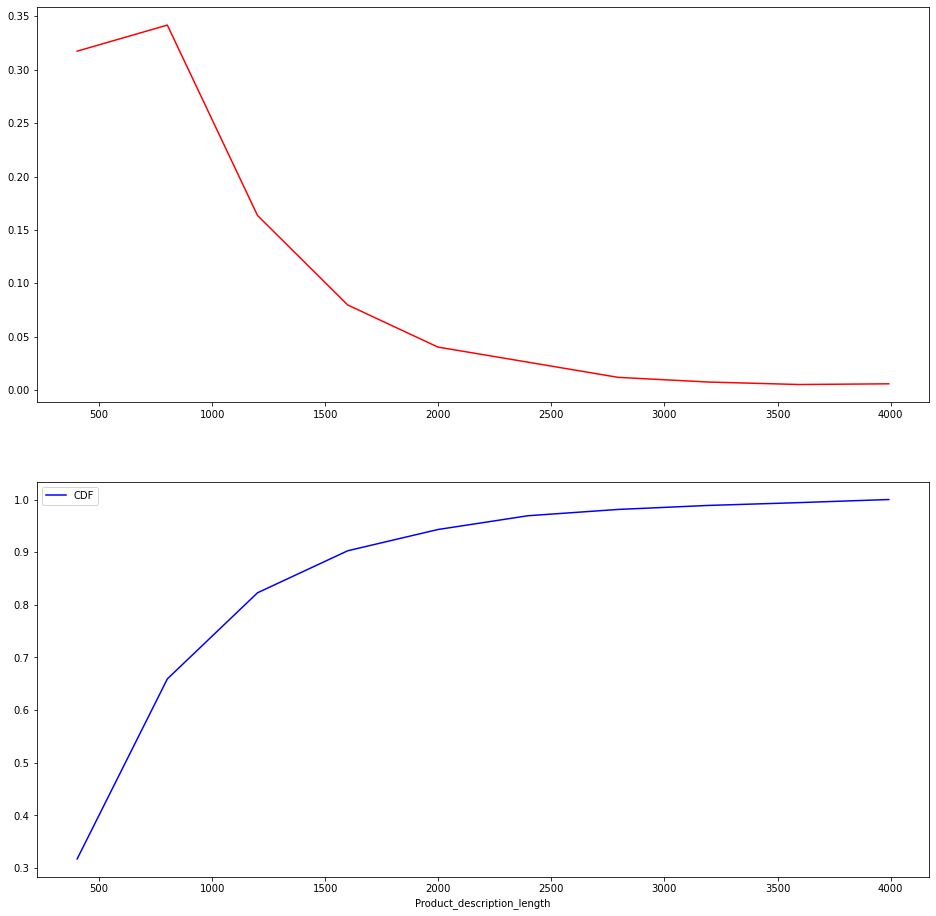

In [26]:
counts, bin_edges = np.histogram(products_data.product_description_length.dropna(), bins=10, 
                                 density = True)
fig,ax = plt.subplots(2,figsize=(16,16))
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
ax[0].plot(bin_edges[1:],pdf,color='red',label='PDF')
ax[1].plot(bin_edges[1:], cdf,color= 'b',label="CDF")
plt.xlabel('Product_description_length')
plt.legend()
plt.show()

**Observations**

* Density plots for product_name_length is dense around (20-60) and product_description length around (0-2000) 

* Above CDF shows that about 92% of the product have product_description_length to be less than or equal to 2000.

* PDF shows that probability of getting product_description_length 500-100 have the maximum probablity.

**Sellers Data**

In [27]:
sellers_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


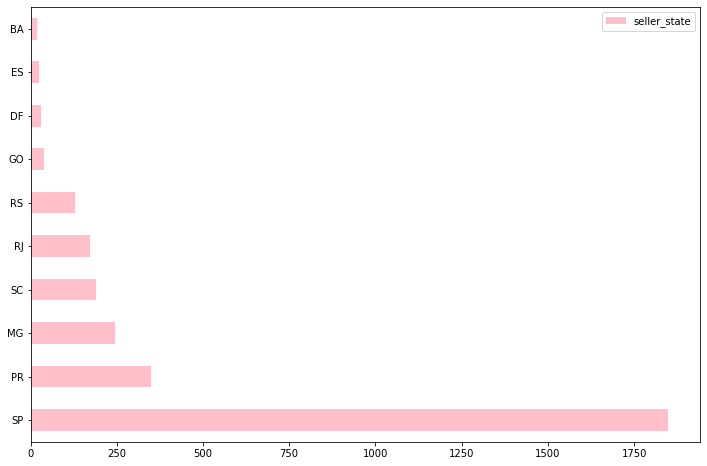

In [28]:
#top 10  seller state
sellers_data.seller_state.value_counts().sort_values(ascending=False)[:10].plot(kind='barh',color='pink',figsize=(12,8))
plt.legend()
plt.show()

In [29]:
#unique sellers
print('Number of unique sellers are: ',sellers_data.seller_id.unique().shape[0])

Number of unique sellers are:  3095


**Observations**

* There are 3095 unique sellers and most of seller are in State SP.

# Data cleaning and preprocessing

In [30]:
#renaming all the zip_code_prefix so as to make the name common in all tables inorder to perform join

geo_data.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)
cust_data.rename(columns={'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)
sellers_data.rename(columns={'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)

In [31]:
#keeping only the unique zip code prefix so that it can act as key to join tables
geo_data.drop_duplicates(subset='zip_code_prefix',inplace=True)
geo_data.shape

(19015, 5)

In [32]:
#merging all customer related data

A = pd.merge(order_data,order_reviews,on='order_id')
A = pd.merge(A,order_payments,on='order_id')
A = pd.merge(A,cust_data,on='customer_id')
#peforming left outer join as we need every geo based address related to customer
A = pd.merge(A,geo_data,how='left',on='zip_code_prefix')
A.shape

(104485, 26)

In [33]:
#merging all seller related data

B = pd.merge(order_items,products_data,on='product_id')
B = pd.merge(B,sellers_data,on='seller_id')
B = pd.merge(B,product_category,on='product_category_name')
#peforming left outer join as we need every geo based address related to seller
B = pd.merge(B,geo_data,how='left',on='zip_code_prefix')
B.shape

(111023, 23)

In [34]:
#merging customer based data to the seller based data

data = pd.merge(A,B,on='order_id')
data.shape

(116581, 48)

In [35]:
#final data columns
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_unique_id',
       'zip_code_prefix_x', 'customer_city', 'customer_state',
       'geolocation_lat_x', 'geolocation_lng_x', 'geolocation_city_x',
       'geolocation_state_x', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'zip_code_prefix_y', 'seller_city', 'seller_state',
    

In [36]:
data.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1213
order_delivered_customer_date      2515
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             102585
review_comment_message            66703
review_creation_date                  0
review_answer_timestamp               0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
customer_unique_id                    0
zip_code_prefix_x                     0
customer_city                         0
customer_state                        0
geolocation_lat_x                   311
geolocation_lng_x                   311
geolocation_city_x                  311


In [37]:
print(data.shape[0])
data[data['order_status'] != 'delivered'].shape[0]

116581


2514

In [38]:
100 - round((2514/112863)*100,3)

97.773

**Observations**

1. There are many features having null/blank entires too , but their proportion is less than 30%, so we can simply remove all such rows.

2. Moreover, we have the product category name in a different language, so we simply rename the english version of the category names to category_name and delete the other.

3. To add on to this , we can clearly remove very detailed information about the product i.e product_description_lenght, product_name_lenght, product_weight_g, product_length_cm, product_height_cm, product_width_cm as they dont decide wheather a customer will like it or not.

4. Only feature in product section that can be useful is number of photos the product has, if it has many photos customer customer is well aware of how the product looks from all possible ways and is more certainly sure about going for it , thus increasing the chance of getting a positive rating.

5. On a similar note , product_description lenght can also act somewhat useful, because if the description of the product is detailed and long , customer is most likely to know evrey crux of the product thus increasing the high rating probability.

6. We dont clearly need latitudinal and longtuditnal info, seller_city(seller state is enough)

7. Order_approved_at is a datetime based feature which is useless, because customer is least intersted when the order was approved, because in almost all case it gets approved instantly or within some minutes or hours. It is a trivial feature.

8. As we have already removed product reviews and review titles , there is no use of review id now.

9. As we have merged all the tables into a single one, so the there is no need some primary key or id. So all id can dropped except the customer unique id which may be useful to study the customer as not all the customers are same and seller_id and product_id

In [39]:
#removing some mis filled data
data = data[data['geolocation_state_y'] == data['seller_state']]

#list of useless feature
useless_features = ['review_comment_title','review_comment_message','product_category_name','product_weight_g','review_creation_date',
                    'product_length_cm','product_height_cm','product_width_cm','seller_city','review_answer_timestamp',
                   'geolocation_lat_y','geolocation_lng_y','geolocation_city_y','geolocation_state_y','review_id','order_approved_at','order_status',
                   'order_id','customer_id','order_item_id','geolocation_lat_x',
                   'geolocation_lng_x','geolocation_city_x','geolocation_state_x']
print('Number of useless features as of now are : ',len(useless_features))

data.drop(useless_features,axis=1,inplace=True)

data.rename(columns = {'product_category_name_english':'product_category_name','zip_code_prefix_x':'zipCode_prefix_cust',
                      'zip_code_prefix_y':'zipCode_prefix_seller'},inplace=True)




Number of useless features as of now are :  24


**Removing all NULL values**

In [40]:
prev_size = data.shape[0]
data.dropna(how='any',inplace=True)

current_size = data.shape[0]
#no Null values now
data.isnull().values.any()
print(data.shape)
print('Only {}% of data got removed'.format(round(((prev_size - current_size)/prev_size)*100,2)))

(113152, 24)
Only 2.16% of data got removed


In [41]:
data.columns

Index(['order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_unique_id',
       'zipCode_prefix_cust', 'customer_city', 'customer_state', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'zipCode_prefix_seller', 'seller_state',
       'product_category_name'],
      dtype='object')

# Exploratory Data Analysis

**Month wise sales**

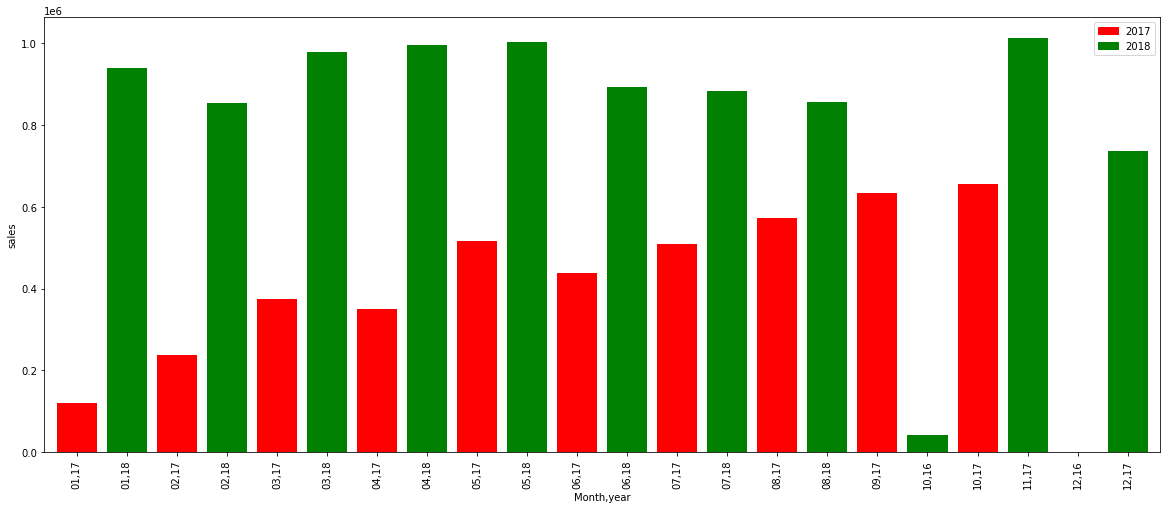

In [42]:
#understanding the growth of Olist as an ecommerce company from the range of data given to us
import matplotlib.patches as mpatches
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
monthly_sales_data = data.groupby(data['order_purchase_timestamp'].dt.strftime('%m,%y'))['price'].sum().plot(kind='bar',figsize = (20,8),color=['r','g'],width=0.8)
plt.ylabel('sales')

red_patch = mpatches.Patch(color='red', label='2017')
green_patch = mpatches.Patch(color='green', label='2018')
plt.legend(handles=[red_patch,green_patch])
plt.xlabel('Month,year')
plt.show()

**State wise sales(Top 10 states with maximum orders)**

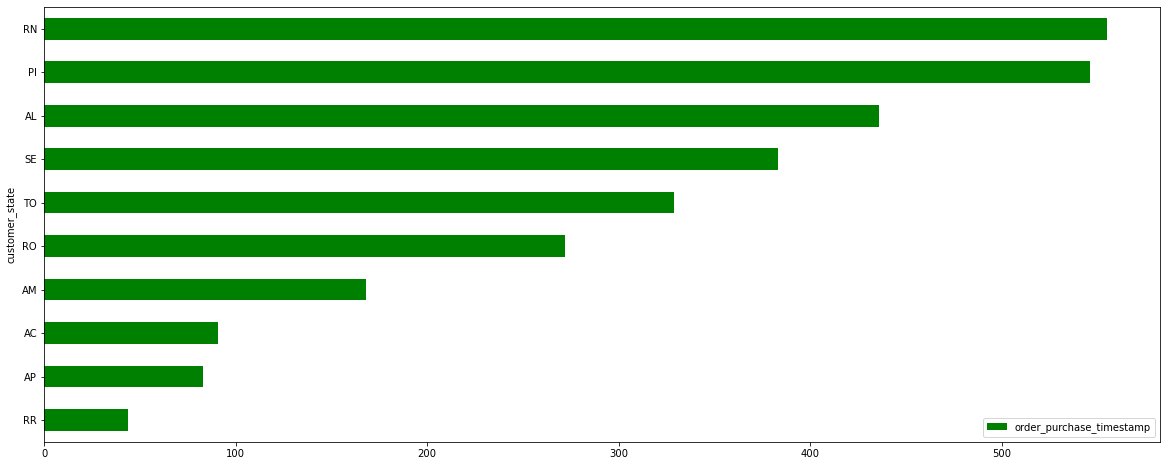

In [43]:
#top 10 states as per number of orders
data.groupby(data['customer_state'])['order_purchase_timestamp'].count().sort_values()[:10].plot(kind='barh',figsize=(20,8),color='green')
plt.legend()
plt.show()

In [44]:
print('Total unique category are ',data.product_category_name.unique().shape[0])

Total unique category are  71


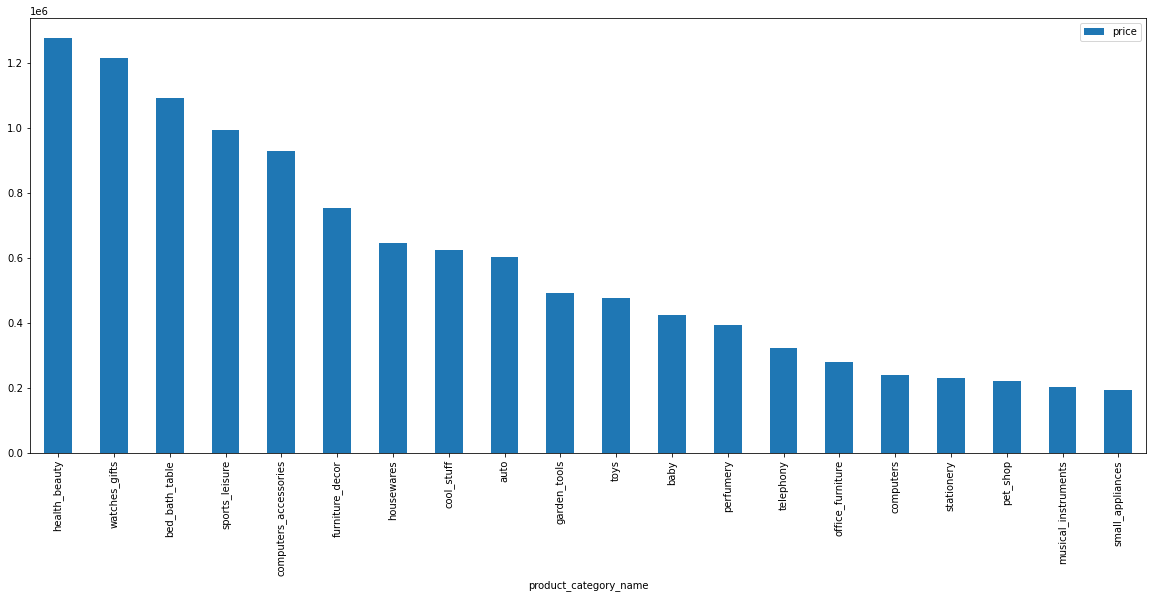

In [45]:
#category wise sales with their rating(top 20)
data.groupby(data['product_category_name'])['price'].sum().sort_values(ascending=False)[:20].plot(kind='bar',figsize=(20,8))
plt.legend()
plt.show()

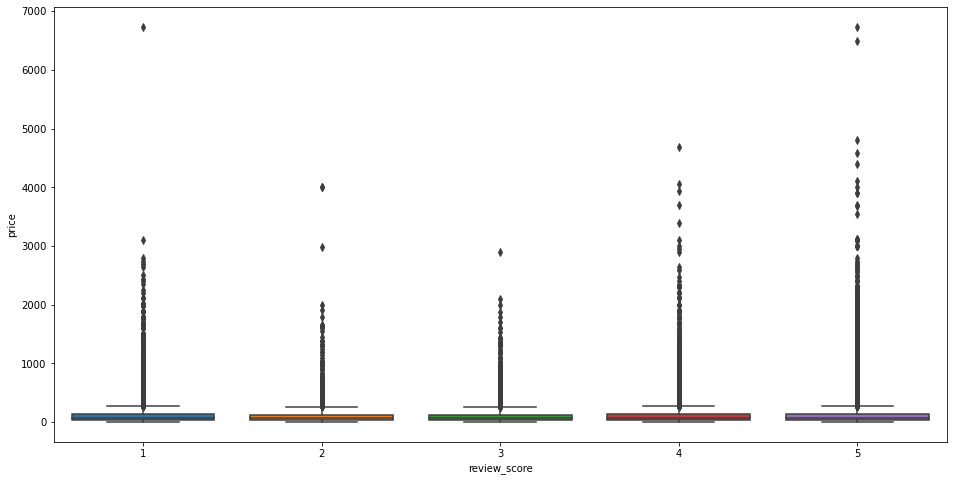

In [46]:
#Box plot for price with review score
plt.figure(figsize= (16,8))
sns.boxplot(x='review_score',y='price', data=data)
plt.show()

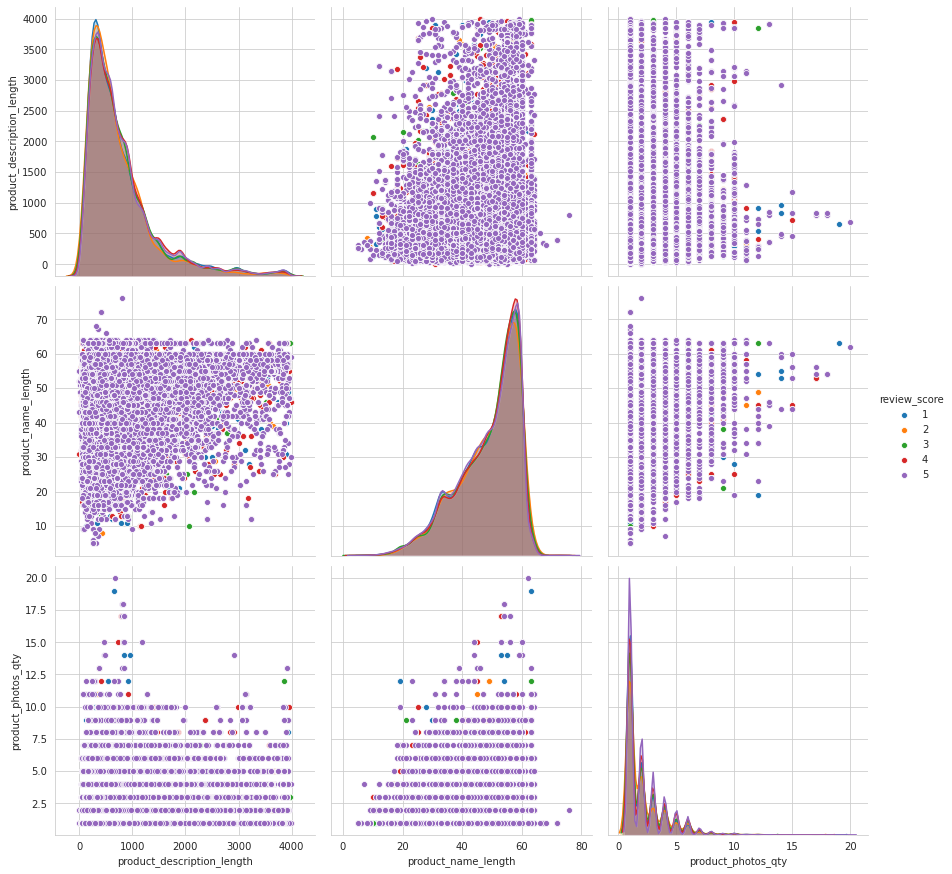

In [47]:
d = data[['product_description_length','product_name_length','product_photos_qty','review_score']]
sns.set_style("whitegrid");
sns.pairplot(d, hue="review_score", height=4);
plt.show()

**Observations**

1. Data is severly immbalaced, so scatter plot is able to separate the classes based on the selected feature

2. Point in the range (0-1500) product_description_length and product_name_length in range(30-60) have high frequency
of 5 rated review.


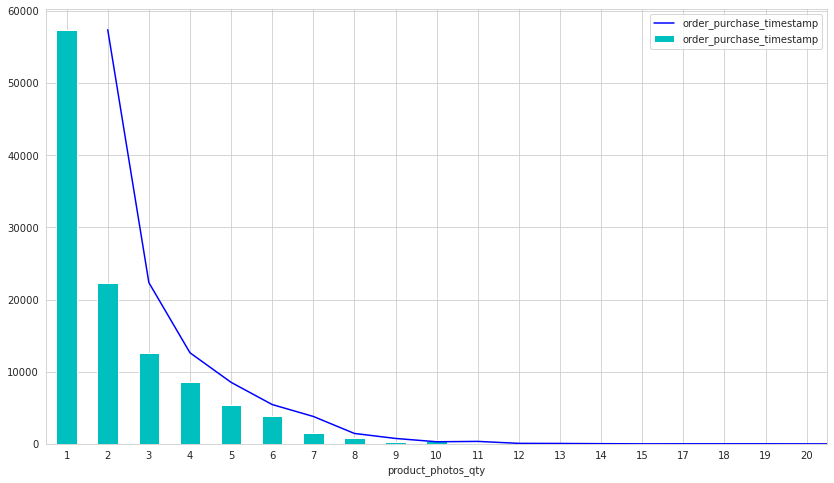

In [48]:
#plot showing relationship among number of photos and the count of number of orders
d = data.groupby(data['product_photos_qty'].astype(int))['order_purchase_timestamp'].count()
d.plot(kind='bar',figsize=(14,8),color='c')
d.plot(kind='line',figsize=(14,8),color='b')
plt.legend()
plt.show()

**Observations**

1. Density plots for the product name length shows that density around is very high around (40-60) range.
2. Number of orders w.r.t number of photos qty starts to decrease with increasing in number of photos which is not
very obvious. This may be because of other feature like product_description length or name length.

**Box plot**

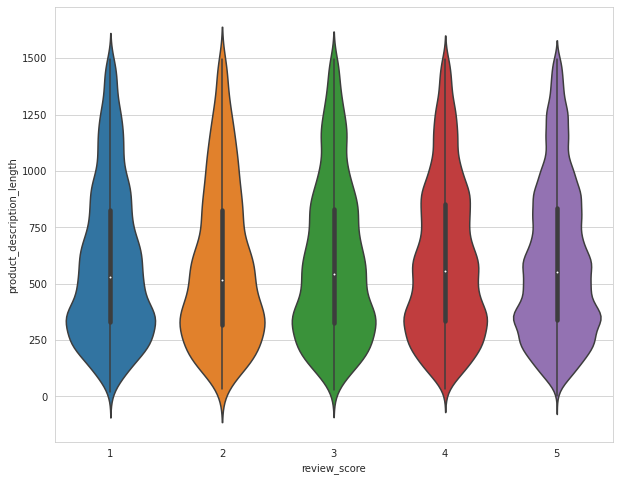

In [49]:
#taking only those points which was shown in the scatter plot
d = data[(data['product_name_length'] > 40) & (data['product_name_length'] < 60) & (data['product_description_length'] < 1500)]

plt.figure(figsize=(10,8))
#box plot
sns.violinplot(x='review_score',y='product_description_length', data=d)
plt.show()

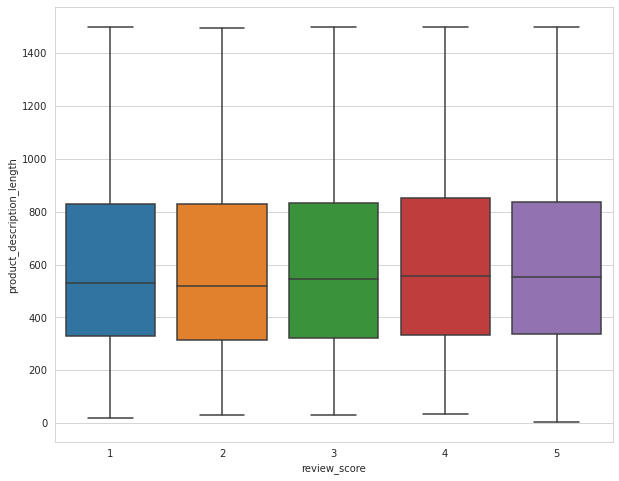

In [50]:
plt.figure(figsize=(10,8))
sns.boxplot(x='review_score',y='product_description_length', data=d)
plt.show()

**Observations**

* Even after taking the most favourable data to clearly separate them out, there is still no separation.

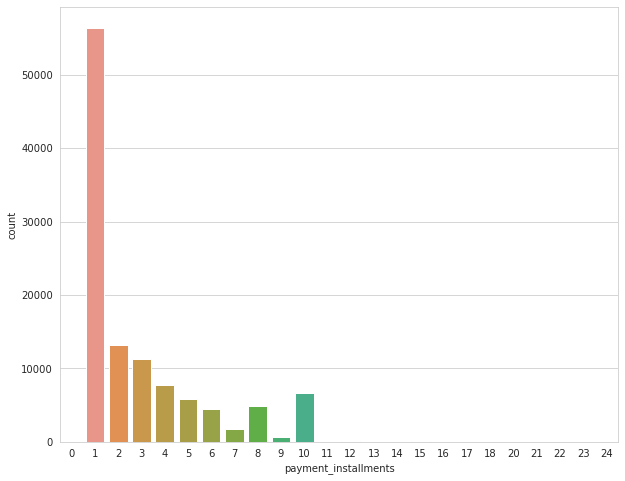

In [51]:
#payments installments
#data.payment_installments.value_counts().plot(kind = 'bar',figsize=(10,8))
plt.figure(figsize=(10,8))
sns.countplot(data.payment_installments)
plt.show()

# Feature Engineering

In [52]:
#converting the timestamp format data to date data as we need just the date and not the exact time
data['order_purchase_timestamp'] = data['order_purchase_timestamp'].dt.date
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date']).dt.date
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date']).dt.date
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date']).dt.date

type(data['order_delivered_customer_date'][0])

datetime.date

In [53]:
#subtracting the order_purchase_time to rest time based feature and converting date time into string to remove the timestamp notation 
data['delivery_days'] = data['order_delivered_customer_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)
data['estimated_days'] = data['order_estimated_delivery_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)
data['ships_in'] = data['shipping_limit_date'].sub(data['order_purchase_timestamp'],axis=0).astype(str)

In [54]:
#replacing the time stamp notation and converting type to int
data['delivery_days'] = data['delivery_days'].str.replace(" days","").astype(int)
data['estimated_days'] = data['estimated_days'].str.replace(" days","").astype(int)
data['ships_in'] = data['ships_in'].str.replace(" days","").astype(int)
data['arrival_time'] = (data['estimated_days'] - data['delivery_days']).apply(lambda x: 'Early/OnTime' if x > 0 else 'Late')

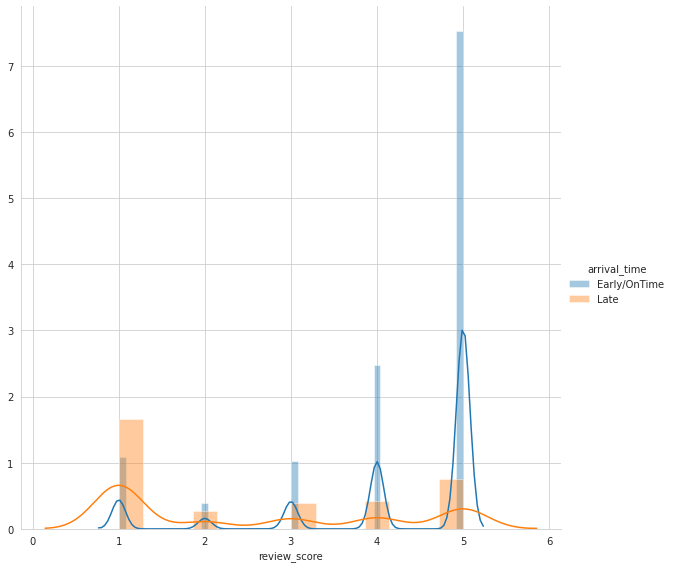

In [55]:
sns.FacetGrid(data, hue="arrival_time", height=8) \
   .map(sns.distplot, 'review_score') \
   .add_legend();
plt.show();

In [56]:
data.arrival_time.value_counts()

Early/OnTime    104285
Late              8867
Name: arrival_time, dtype: int64

**Observations**

1. Clearly from the above plot the cutomers are more likely to give an 4-5 rating if the product either arrives early or arrive on time.

2. As delivery time impacts a lot to the customer rating we will do further analysis on the delivery time.


In [57]:
#dropping exceptional delivery or possible outliers
ix = data[(data['delivery_days'] > 60) | (data['estimated_days'] > 60) | (data['ships_in'] > 60)].index
print(ix.shape)

print('Percentage of extermely late delivered packages in the dataset is: {}%'.format(round((((ix.shape[0])/(data.shape[0])))*100,3)))
#we can remove those outliers
data.drop(ix,inplace=True)

(625,)
Percentage of extermely late delivered packages in the dataset is: 0.552%


In [58]:
#binning and grouping delivery times into groups or classes

delivery_feedbacks = []
estimated_del_feedbacks = []
shipping_feedback = []
d_days = data.delivery_days.values.tolist()
est_days = data.estimated_days.values.tolist()
ship_days = data.ships_in.values.tolist()

#actural delivery days
for i in d_days:
    if i in range(0,8):
        delivery_feedbacks.append('Very_Fast')
    elif i in range(8,16):
        delivery_feedbacks.append('Fast')
    elif i in range(16,25):
        delivery_feedbacks.append('Neutral')
    elif i in range(25,40):
        delivery_feedbacks.append('Slow')
    elif i in range(40,61):
        delivery_feedbacks.append('Worst')

#estimated delivery days
for i in est_days:
    if i in range(0,8):
        estimated_del_feedbacks.append('Very_Fast')
    elif i in range(8,16):
        estimated_del_feedbacks.append('Fast')
    elif i in range(16,25):
        estimated_del_feedbacks.append('Neutral')
    elif i in range(25,40):
        estimated_del_feedbacks.append('Slow')
    elif i in range(40,61):
        estimated_del_feedbacks.append('Worst')

#estimated shipping days
for i in ship_days:
    if i in range(0,4):
        shipping_feedback.append('Very_Fast')
    elif i in range(4,8):
        shipping_feedback.append('Fast')
    elif i in range(8,16):
        shipping_feedback.append('Neutral')
    elif i in range(16,28):
        shipping_feedback.append('Slow')
    elif i in range(28,61):
        shipping_feedback.append('Worst')

#putting list values into the dataframe as feature
data['delivery_impression'] = delivery_feedbacks
data['estimated_del_impression'] = estimated_del_feedbacks
data['ship_impression'] = shipping_feedback

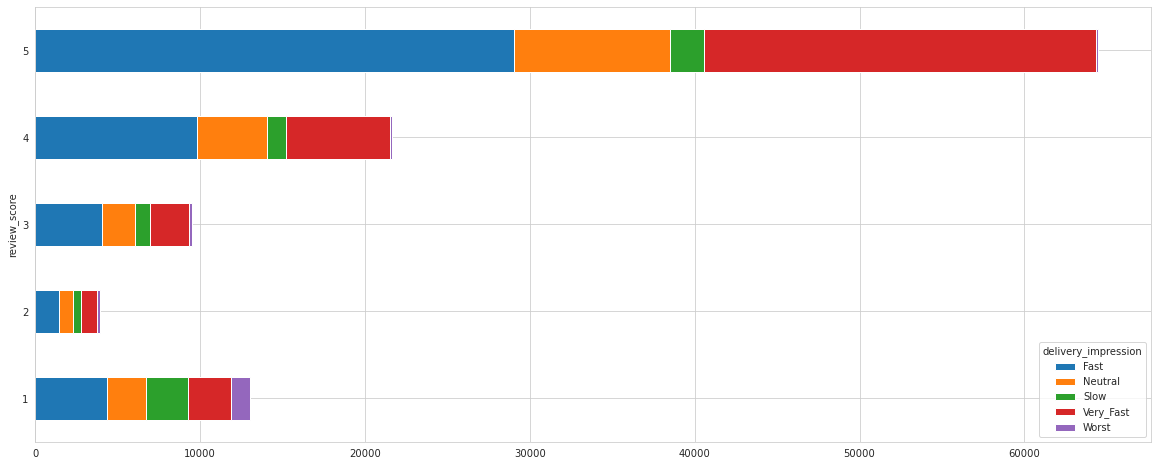

In [59]:
#Delivery Days histogram with review rating as hue
df_plot = data.groupby(['delivery_impression', 'review_score']).size().reset_index().pivot(columns='delivery_impression', index='review_score', values=0)
df_plot.plot(kind='barh',stacked=True,figsize=(20,8))

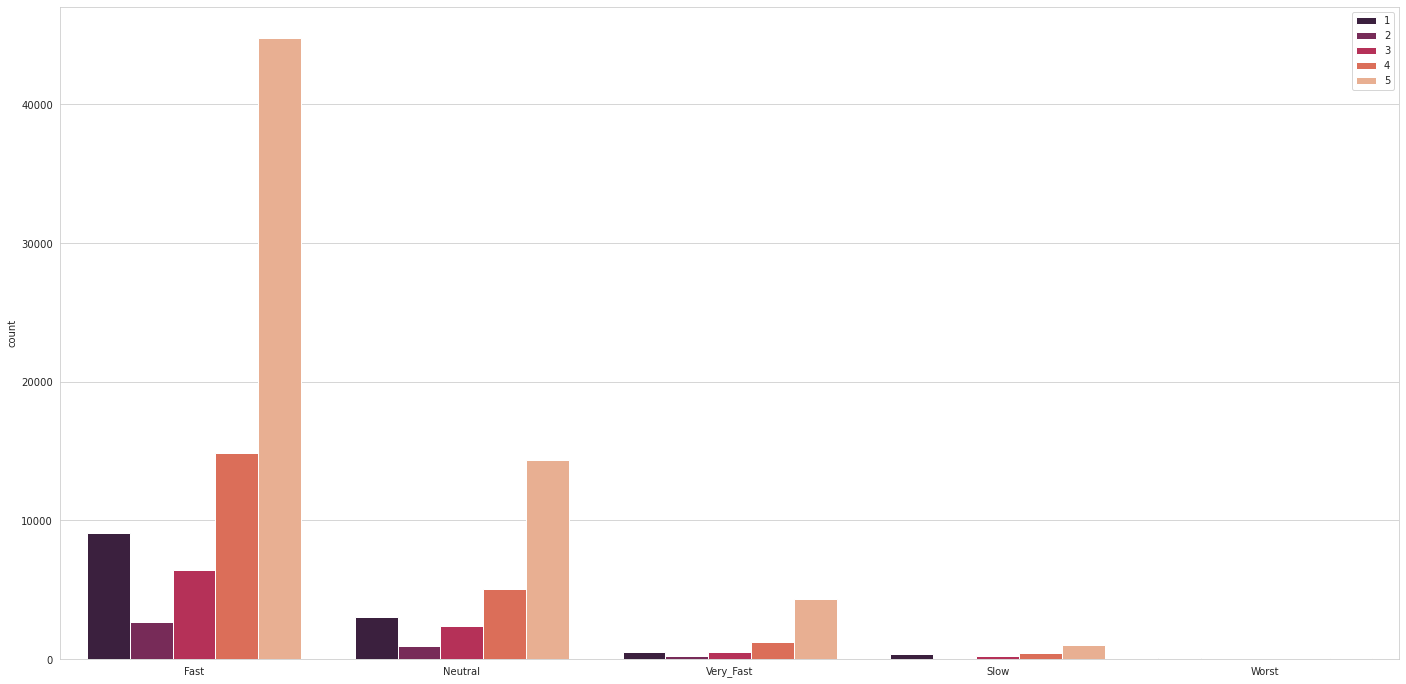

In [60]:
#Estimated Days histogram with review rating as hue
est_days = data.ship_impression.values.tolist()
review_score = data.review_score.values
fig = plt.figure(figsize=(24,12))
sns.countplot(est_days,hue=review_score,palette='rocket')
plt.show()

**Observations**


1. Majority of orders are delivered in the Fast range i.e (8-15) within 2 weeks .

2. However, next to it Very Fast range of delivery days which is (0-7) days.

3. Important observation here is customers are more likely to get things delivered in top 3 categories which are Fast,Very Fast and Neutral. From which majority of elment have rated the product to be 5 , some 4 while very few have rated less than in each of the 3 cases.

4. Delivery days is thus an important feature which can be added.


5. Moreover we have another feature which is estmated delivery date, so we also add a new feature to the dataset which is estimated delivery days. This can be some what useful, because this date is shown in advance to the user.

6. In the estimated delivery days feature though, company says out the maximum days it can take to reach. 

7. Upon observing the histograms for the estimated_days with rating as hue, similar trend of maximum rating for all the Fast Neutral and slow category. However, very fast category becomes one of the least. 


# Feature Engineering for ID based features

**Customer_ID **

In [61]:
from collections import Counter
#finding all those customers who have made multiple product purchases
order_counts = [k for k,v in Counter(data.customer_unique_id).items() if v > 1]
existing_cust = []
for i in data.customer_unique_id.values:
    if i in order_counts:
        existing_cust.append(1)
    else:
        existing_cust.append(0)
len(existing_cust)

112527

*Seller_ID*

In [62]:
print('Number of orders that are made using exisiting customer/Multiple orders are ',existing_cust.count(1))

Number of orders that are made using exisiting customer/Multiple orders are  35326


In [63]:
#seller popularity based on number of orders for each seller
max_value_count = data.seller_id.value_counts().max()
seller = data.seller_id.value_counts().to_dict()
seller_popularity = []
for _id in data.seller_id.values:
    seller_popularity.append(seller[_id])
data['seller_popularity'] = seller_popularity
data.shape

(112527, 32)

**Observations**

* As in most of the cases customer and seller zip_code are not matching so we are dropping the featrure
 because it will increase dimenssion by 34k.

In [64]:
#dropping all id based features
data.drop(['customer_unique_id','seller_id','product_id','zipCode_prefix_seller','zipCode_prefix_cust'],axis=1,inplace=True)

#adding exisitng customer and seller_ID feature

data['existing_cust'] = existing_cust
data.shape

(112527, 28)

In [65]:
#if score> 3, set score = 1
#if score<=3, set score = 0 
data.loc[data['review_score'] < 3 ,'Score'] = 0
data.loc[data['review_score'] > 3,'Score'] = 1
#removing neutral reviews
data.drop(data[data['review_score'] == 3].index,inplace=True)
data.drop('review_score',axis=1,inplace=True)
print(data.shape)

(103030, 28)


In [66]:
#removing the datetime features as we dont need them now
data.drop(['order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date'],axis=1,inplace=True)
data.to_csv('preprocessed_data.csv',index=False)

In [67]:
print(data.shape)
print('Final set of features are : ')
data.columns

(103030, 23)
Final set of features are : 


Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_city', 'customer_state', 'price',
       'freight_value', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'seller_state', 'product_category_name',
       'delivery_days', 'estimated_days', 'ships_in', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'existing_cust', 'Score'],
      dtype='object')

# Summary


* Data is heavily imbalanced having mostly positive review_score, this can impact the model so we have to perform necessiry data modelling to deal with this. 

* From above analysis it is quite conclusive that the review_score highly depends on the delivery time, however some of the rest features are also useful but we need actual model to determine feature importances.

* Other features like price , product name length, description length can be very useful feature, but as the data is immbalace it can not be simple EDA.

* We have added few more features to the dataset that coresponds to the delivery and shipment.

* We will be strict about sentiments in this analysis and consider even neutral or (3 rating) to be negetive because for product recommendation the stricter the benchmark is the better.

* Feature engineering done here might not be suffiicient to obtain the best accuracy so we might need to perform some more feature engineering.

# *Modelling*

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve,auc
import itertools
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [69]:
data = pd.read_csv('preprocessed_data.csv')
data.columns

Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_city', 'customer_state', 'price',
       'freight_value', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'seller_state', 'product_category_name',
       'delivery_days', 'estimated_days', 'ships_in', 'arrival_time',
       'delivery_impression', 'estimated_del_impression', 'ship_impression',
       'seller_popularity', 'existing_cust', 'Score'],
      dtype='object')

In [70]:
data.shape

(103030, 23)

In [71]:
#spliting data to train and test data
X = data.drop('Score',axis=1)
Y = data.Score.values

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.33,stratify=Y,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(69030, 22) (34000, 22) (69030,) (34000,)


# Normalising all the numerical features

In [72]:
std_scaler = Normalizer()
min_max = MinMaxScaler()

#payment_sequential feature
payment_sequential_train = std_scaler.fit_transform(X_train.payment_sequential.values.reshape(-1,1))
payment_sequential_test = std_scaler.transform(X_test.payment_sequential.values.reshape(-1,1))

#payment_installments feature
payment_installments_train = std_scaler.fit_transform(X_train.payment_installments.values.reshape(-1,1))
payment_installments_test = std_scaler.transform(X_test.payment_installments.values.reshape(-1,1))

#Payment value feature
payment_value_train = std_scaler.fit_transform(X_train.payment_value.values.reshape(-1,1))
payment_value_test = std_scaler.transform(X_test.payment_value.values.reshape(-1,1))


#price
price_train = std_scaler.fit_transform(X_train.price.values.reshape(-1,1))
price_test = std_scaler.transform(X_test.price.values.reshape(-1,1))

#freight_value
freight_value_train = std_scaler.fit_transform(X_train.freight_value.values.reshape(-1,1))
freight_value_test = std_scaler.transform(X_test.freight_value.values.reshape(-1,1))

#product_name_length
product_name_length_train = std_scaler.fit_transform(X_train.product_name_length.values.reshape(-1,1))
product_name_length_test = std_scaler.transform(X_test.product_name_length.values.reshape(-1,1))


#product_description_length
product_description_length_train = std_scaler.fit_transform(X_train.product_description_length.values.reshape(-1,1))
product_description_length_test = std_scaler.transform(X_test.product_description_length.values.reshape(-1,1))


#product_photos_qty
product_photos_qty_train = std_scaler.fit_transform(X_train.product_photos_qty.values.reshape(-1,1))
product_photos_qty_test = std_scaler.transform(X_test.product_photos_qty.values.reshape(-1,1))


#delivery_days
delivery_days_train = std_scaler.fit_transform(X_train.delivery_days.values.reshape(-1,1))
delivery_days_test = std_scaler.transform(X_test.delivery_days.values.reshape(-1,1))


#estimated_days
estimated_days_train = std_scaler.fit_transform(X_train.estimated_days.values.reshape(-1,1))
estimated_days_test = std_scaler.transform(X_test.estimated_days.values.reshape(-1,1))


#ships_in
ships_in_train = std_scaler.fit_transform(X_train.ships_in.values.reshape(-1,1))
ships_in_test = std_scaler.transform(X_test.ships_in.values.reshape(-1,1))

#seller_popularity
seller_popularity_train = min_max.fit_transform(X_train.seller_popularity.values.reshape(-1,1))
seller_popularity_test = min_max.transform(X_test.seller_popularity.values.reshape(-1,1))

# Normalising Categorical features

In [73]:
#initialising oneHotEncoder

onehot = CountVectorizer()
cat = OneHotEncoder()
#payment_type
payment_type_train = onehot.fit_transform(X_train.payment_type.values)
payment_type_test = onehot.transform(X_test.payment_type.values)


#customer_state
customer_state_train = onehot.fit_transform(X_train.customer_state.values)
customer_state_test = onehot.transform(X_test.customer_state.values)

#seller_state
seller_state_train = onehot.fit_transform(X_train.seller_state.values)
seller_state_test = onehot.transform(X_test.seller_state.values)


#product_category_name
product_category_name_train = onehot.fit_transform(X_train.product_category_name.values)
product_category_name_test = onehot.transform(X_test.product_category_name.values)


#arrival_time
arrival_time_train = onehot.fit_transform(X_train.arrival_time.values)
arrival_time_test = onehot.transform(X_test.arrival_time.values)

#delivery_impression
delivery_impression_train = onehot.fit_transform(X_train.delivery_impression.values)
delivery_impression_test = onehot.transform(X_test.delivery_impression.values)


#estimated_del_impression
estimated_del_impression_train = onehot.fit_transform(X_train.estimated_del_impression.values)
estimated_del_impression_test = onehot.transform(X_test.estimated_del_impression.values)

#ship_impression
ship_impression_train = onehot.fit_transform(X_train.ship_impression.values)
ship_impression_test = onehot.transform(X_test.ship_impression.values)


#existing_cust
existing_cust_train = cat.fit_transform(X_train.existing_cust.values.reshape(-1,1))
existing_cust_test = cat.transform(X_test.existing_cust.values.reshape(-1,1))

**Stacking the data**

In [74]:
#stacking up all the encoded features
X_train_vec = hstack((payment_sequential_train,payment_installments_train,payment_value_train,price_train,
                      freight_value_train,product_name_length_train,product_description_length_train,
                      product_photos_qty_train,delivery_days_train,estimated_days_train,ships_in_train,
                      payment_type_train,customer_state_train,seller_state_train,product_category_name_train,
                      arrival_time_train,delivery_impression_train,estimated_del_impression_train,
                     ship_impression_train,seller_popularity_train))

X_test_vec = hstack((payment_sequential_test,payment_installments_test,payment_value_test,price_test,
                      freight_value_test,product_name_length_test,product_description_length_test,
                      product_photos_qty_test,delivery_days_test,estimated_days_test,ships_in_test,
                      payment_type_test,customer_state_test,seller_state_test,product_category_name_test,
                      arrival_time_test,delivery_impression_test,estimated_del_impression_test,
                     ship_impression_test,seller_popularity_test))

print(X_train_vec.shape,X_test_vec.shape)

(69030, 153) (34000, 153)


# Naive Bayes

# Hyper parameter Tuning

In [75]:
naive = MultinomialNB(class_prior=[0.5,0.5])

param = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000]}

#for the bow based model
NB = GridSearchCV(naive,param,cv=3,refit=False,return_train_score=True,scoring='roc_auc')
NB.fit(X_train_vec,y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [76]:
NB.best_params_

{'alpha': 0.1}

# Fitting the Model

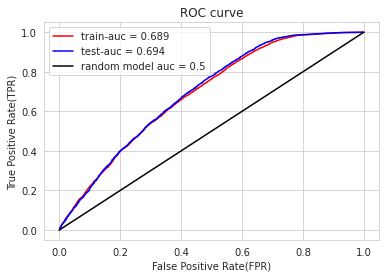

Best AUC for the model is 0.694 


In [77]:
clf = MultinomialNB(alpha=0.0001,class_prior=[0.5,0.5])
clf.fit(X_train_vec,y_train)

#predicted value of y probabilities
y_pred_train = clf.predict_proba(X_train_vec)
y_pred_test = clf.predict_proba(X_test_vec)

#predicted values of Y labels
pred_label_train = clf.predict(X_train_vec)
pred_label_test = clf.predict(X_test_vec)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),3)
test_auc = round(auc(fpr_test,tpr_test),3)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

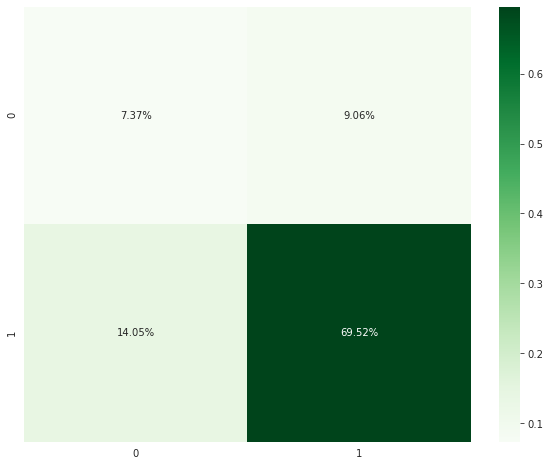

In [78]:
#plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
plt.show()

In [79]:
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

Train F1_score for this model is :  0.8568
Test F1_score for this model is :  0.8575


In [80]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

Train Accuracy score for this model :  0.7674
Test Accuracy score for this model :  0.7689


# Observations

1. Naive bayes performed pretty decent in terms of minimal overfitting in train and test performances.
2. Both train and test f1 score was 0.86 and accuracy 77%.
3. But the confusion matrix says it has misclassified many points as False Positives.
4. AUC score for test data was 0.694.

# Logistic Regression

# Hyper parameter Tuning

In [81]:
#we have used max_iter 1000 as it was causing exception while fitting
Logi = LogisticRegression(max_iter=1000,solver='lbfgs')

param = {'C': [0.0001,0.001,0.01,0.1,1,10,20,30]}

#for the bow based model
LR = GridSearchCV(Logi,param,cv=3,refit=False,return_train_score=True,scoring='roc_auc')
LR.fit(X_train_vec,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 30]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [82]:
LR.best_params_

{'C': 0.1}

**NOTE**

* For performance measurement we will not use accuracy as a metric as the data set is highly imbalanced.
* We will use AUC score and f1 score as performance metric.

In [83]:
#model
clf = LogisticRegression(C=0.1,max_iter=1000,solver='lbfgs')
clf.fit(X_train_vec,y_train)

LogisticRegression(C=0.1, max_iter=1000)

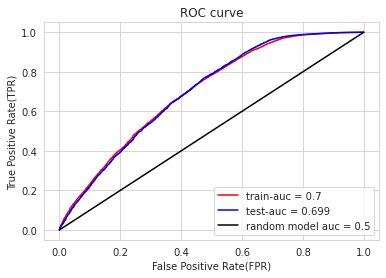

Best AUC for the model is 0.699 


In [84]:
#predicted value of y probabilities
y_pred_train = clf.predict_proba(X_train_vec)
y_pred_test = clf.predict_proba(X_test_vec)

#predicted values of Y labels
pred_label_train = clf.predict(X_train_vec)
pred_label_test = clf.predict(X_test_vec)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),3)
test_auc = round(auc(fpr_test,tpr_test),3)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

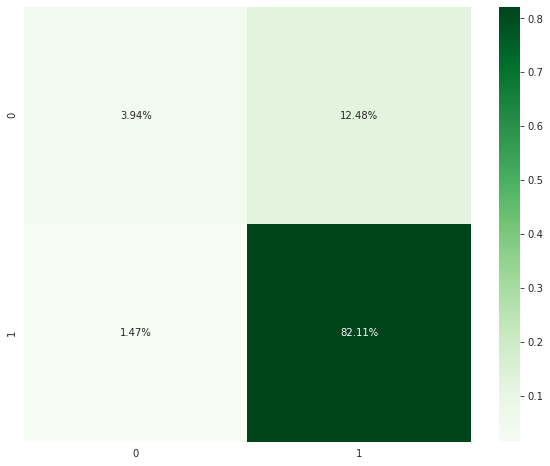

In [85]:
#plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
plt.show()

In [86]:
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

Train F1_score for this model is :  0.9199
Test F1_score for this model is :  0.9217


In [87]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

Train Accuracy score for this model :  0.8572
Test Accuracy score for this model :  0.8605


# Observations

1. Logistic regression performs considerably better than Naive bayes in terms of f1 score, however AUC score being almost the same.
2. Misclassification of False positives reduced which resulted in the increase of f1 score of 92%.
3. Accuracy was 86% for both train and test which shows the model doesn't overfit at all.

# Decision Tree

# HyperParmater tuning

In [88]:
#model initialize
DT = DecisionTreeClassifier(class_weight='balanced')

#hyper parameters
param = {'max_depth':  [1, 5,10,15,20], 'min_samples_split': [5, 10, 100, 300,500,1000]}

#Grid search CV
DT = GridSearchCV(DT,param,cv=3,refit=False,return_train_score=True,scoring='roc_auc')
DT.fit(X_train_vec,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'min_samples_split': [5, 10, 100, 300, 500, 1000]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [89]:
#best params
DT.best_params_

{'max_depth': 20, 'min_samples_split': 300}

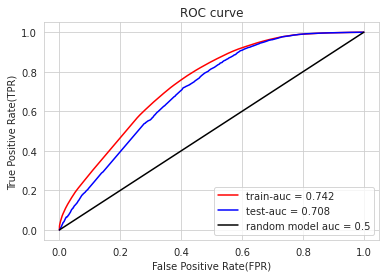

Best AUC for the model is 0.708 


In [90]:
#model
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=20,min_samples_split=300)
clf.fit(X_train_vec,y_train)


#predicted value of y probabilities
y_pred_train = clf.predict_proba(X_train_vec)
y_pred_test = clf.predict_proba(X_test_vec)

#predicted values of Y labels
pred_label_train = clf.predict(X_train_vec)
pred_label_test = clf.predict(X_test_vec)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),3)
test_auc = round(auc(fpr_test,tpr_test),3)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

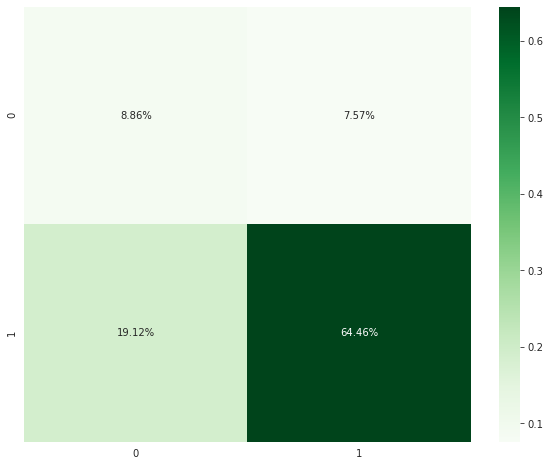

In [91]:
#plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
plt.show()

In [92]:
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

Train F1_score for this model is :  0.8373
Test F1_score for this model is :  0.8285


In [93]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

Train Accuracy score for this model :  0.7468
Test Accuracy score for this model :  0.7331


# Observations

1. Decision Tree does nothing better interms of both f1 score , auc score and accuracy comes out to be 0.708 and 70%.
2. It misclassfied False Positives to a lot.
3. Model doesn't overfit but doesn't perform better either.

# Random Forest

# Hyperparameter Tuning

In [94]:
#param grid
#we have limit max_depth to 10 so that the model doesn't overfit
param = { 'min_samples_split':[5,10,30,50,100],'max_depth':[5,7,10]}

#Random forest classifier
RFclf = RandomForestClassifier(class_weight='balanced')

#using grid search cv to tune parameters
RF = GridSearchCV(RFclf,param,cv=5,refit=False,n_jobs=-1,verbose=1,return_train_score=True,scoring='roc_auc')
RF.fit(X_train_vec,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'min_samples_split': [5, 10, 30, 50, 100]},
             refit=False, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [95]:
RF.best_params_

{'max_depth': 10, 'min_samples_split': 10}

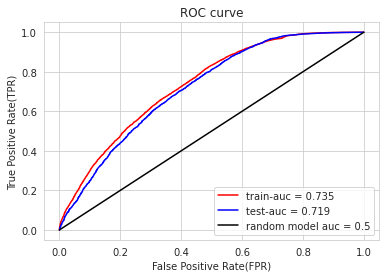

Best AUC for the model is 0.719 


In [96]:
#model
clf = RandomForestClassifier(class_weight='balanced',max_depth=10,min_samples_split=5)
clf.fit(X_train_vec,y_train)


#predicted value of y probabilities
y_pred_train = clf.predict_proba(X_train_vec)
y_pred_test = clf.predict_proba(X_test_vec)

#predicted values of Y labels
pred_label_train = clf.predict(X_train_vec)
pred_label_test = clf.predict(X_test_vec)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),3)
test_auc = round(auc(fpr_test,tpr_test),3)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

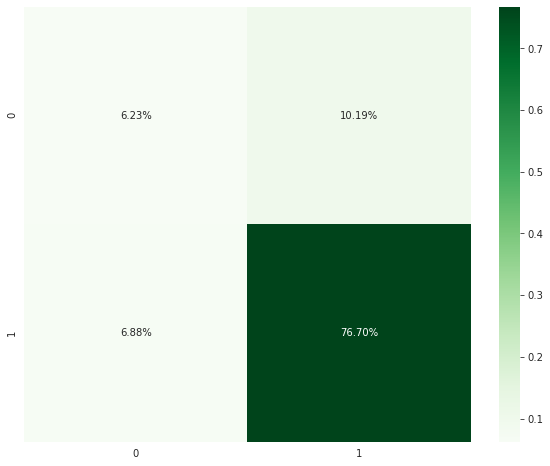

In [97]:
#plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
plt.show()

In [98]:
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

Train F1_score for this model is :  0.9017
Test F1_score for this model is :  0.8999


In [99]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

Train Accuracy score for this model :  0.8322
Test Accuracy score for this model :  0.8293


# Observations

1. Random forest performs better than logistic regression in terms of f1 score and accuracy.
2. It gives an f1 score of 90.13% and doesn't seem to overfit.
3. Misclassification rate is still not that great.
4. AUC is score is 0.718
5. Accuracy score is 83%.

# GBDT

# Hyper parameter tuning

In [100]:
#param grid
#we have limit max_depth to 8 so that the model doesn't overfit
param = { 'min_samples_split' : [5,10,30,50],'max_depth' : [3,5,7,8]}

GBDTclf = GradientBoostingClassifier()

clf = GridSearchCV(RFclf,param,cv=5,refit=False,return_train_score=True,scoring='roc_auc')
clf.fit(X_train_vec,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_split': [5, 10, 30, 50]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [101]:
#best parameters
clf.best_params_

{'max_depth': 8, 'min_samples_split': 10}

In [102]:
import pickle

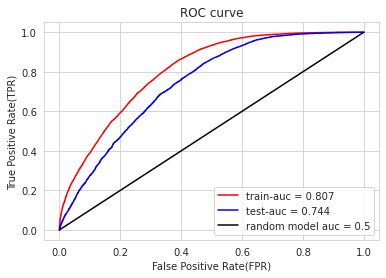

Best AUC for the model is 0.744 


In [103]:
#Model
clf = GradientBoostingClassifier(max_depth=8,min_samples_split=5)
clf.fit(X_train_vec,y_train)

# save the model to disk
Pkl_Filename = "final_model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

#predicted value of y probabilities
y_pred_train = clf.predict_proba(X_train_vec)
y_pred_test = clf.predict_proba(X_test_vec)

#predicted values of Y labels
pred_label_train = clf.predict(X_train_vec)
pred_label_test = clf.predict(X_test_vec)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),3)
test_auc = round(auc(fpr_test,tpr_test),3)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

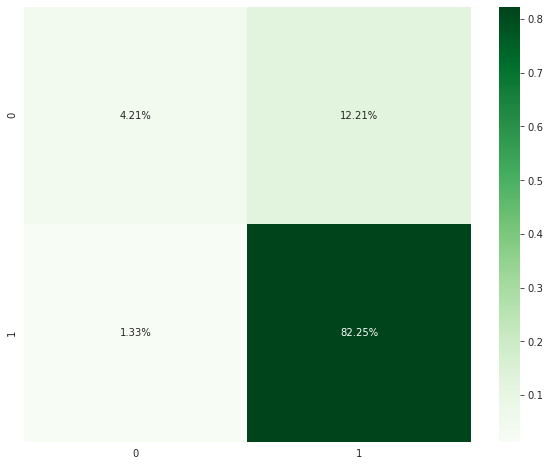

In [104]:
#plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
plt.show()

In [105]:
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

Train F1_score for this model is :  0.9291
Test F1_score for this model is :  0.924


In [106]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

Train Accuracy score for this model :  0.8736
Test Accuracy score for this model :  0.8646


# Observations

1. Gradient Boosted classifier results the best f1 score of 0.9243 and auc score of 0.745.
2. Misclassification of False Positives and True negetives is also reduced to 11% also true positive rate is 83%.
3. Accuracy score is 86% for test and 87% for train data.
4. Model does overfit a slight comapred to rest of the models.

# Standard Neural Network based model


In [107]:
#setting input length to number of features
input_length = X_train_vec.shape[1]

In [108]:
##imports
import os
import sys
import os
import random as rn
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D,Conv1D, MaxPool1D, Embedding,concatenate,Flatten,Dropout,LSTM,Concatenate,LeakyReLU
from tensorflow.keras.models import Model

In [109]:
##create an NN and train
os.environ['PYTHONHASHSEED'] = '0'
## Set the random seed values to regenerate the model.
tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

#input layer
input_layer = Input(shape=(input_length,1))

#Conv layer
Conv1 = Conv1D(filters=10,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_initializer='he_normal',name='Conv1')(input_layer)

#Conv layer
Conv2 = Conv1D(filters=10,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_initializer='he_normal',name='Conv2')(Conv1)

#Conv layer
Conv3 = Conv1D(filters=10,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_initializer='he_normal',name='Conv3')(Conv2)


#MaxPool Layer
pool1 = MaxPool1D(5)(Conv3)

#Flatten Layer
flatten_1 = Flatten()(pool1)

#Batch Normalisation to ensure the training is fast
BM = BatchNormalization()(flatten_1)

#FC layer
FC1 = Dense(units=64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001),name='FC1')(BM)

#dropout
drop1 = Dropout(rate = 0.5)(FC1)

#Batch Noramlisation
BM2 = BatchNormalization()(drop1)

#FC layer
FC3 = Dense(units=32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001),name='FC3')(BM2)
# FC3= LeakyReLU(alpha = 0.3)(FC3)

#output layer
Out = Dense(units=2,activation='softmax',name='Output')(FC3)

model = Model(inputs=input_layer,outputs=Out)


model.summary()
# tf.keras.utils.plot_model(model, "model_3.png", show_shapes=True)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 153, 1)]          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 151, 10)           40        
_________________________________________________________________
Conv2 (Conv1D)               (None, 149, 10)           310       
_________________________________________________________________
Conv3 (Conv1D)               (None, 147, 10)           310       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 290)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 290)              

In [110]:
X_train_vec = np.expand_dims(X_train_vec.toarray(),2)
X_test_vec = np.expand_dims(X_test_vec.toarray(),2)

In [111]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [112]:
#auc roc score can be undefined if no data from one class is present in the batch
#so handling such case with custom auc_roc function which returns [0.5,0.5] if there are no points for one class
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

In [113]:
#callbacks
from tensorflow.keras.callbacks import *

#TensorBoard Callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0.002,verbose = 1)
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [114]:
#compiling and fitting the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=[auroc])
model.fit(X_train_vec,y_train,batch_size=512,workers=16,epochs=20,callbacks=[tensorboard_callback,reduce_lr_1],validation_data=(X_test_vec,y_test))

Epoch 1/20
135/135 [==============================] - 7s 54ms/step - loss: 0.7207 - auroc: 0.6075 - val_loss: 0.5749 - val_auroc: 0.6351
Epoch 2/20
135/135 [==============================] - 7s 55ms/step - loss: 0.5438 - auroc: 0.6489 - val_loss: 0.5314 - val_auroc: 0.6722
Epoch 3/20
135/135 [==============================] - 7s 53ms/step - loss: 0.5073 - auroc: 0.6607 - val_loss: 0.4929 - val_auroc: 0.6870
Epoch 4/20
135/135 [==============================] - 8s 60ms/step - loss: 0.4806 - auroc: 0.6684 - val_loss: 0.4635 - val_auroc: 0.6929
Epoch 5/20
135/135 [==============================] - 7s 52ms/step - loss: 0.4621 - auroc: 0.6715 - val_loss: 0.4472 - val_auroc: 0.6978
Epoch 6/20
135/135 [==============================] - 7s 51ms/step - loss: 0.4462 - auroc: 0.6794 - val_loss: 0.4347 - val_auroc: 0.6975
Epoch 7/20
135/135 [==============================] - 7s 51ms/step - loss: 0.4349 - auroc: 0.6802 - val_loss: 0.4229 - val_auroc: 0.6984
Epoch 8/20
135/135 [=====================

In [115]:
pred_label_train = model.predict(X_train_vec)
pred_label_train = [1 if x[1] > x[0] else 0 for x in pred_label_train]
pred_label_test = model.predict(X_test_vec)
pred_label_test = [1 if x[1] > x[0] else 0 for x in pred_label_test]

In [116]:
#Please run train_test split cell to represent y_train and y_test in 1D vector instead of onehot encoded vector.
#f1 score
print('Train F1_score for this model is : ',round(f1_score(y_train,pred_label_train),4))
print('Test F1_score for this model is : ',round(f1_score(y_test,pred_label_test),4))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [117]:
print('Train Accuracy score for this model : ',round(accuracy_score(y_train,pred_label_train),4))
print('Test Accuracy score for this model : ',round(accuracy_score(y_test,pred_label_test),4))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

# Observations

1. We created a standard deep Neural network model and trained it for 20 epochs this resulted f1 score very similar to our best ML model yet which is GBDT.
2. Kindly note that this neural network was very little hyper-parameter tuning done,and still results in a very decent performance.
3. However the auc score of GBDT is still better than the NN model.
4. Important thing to note that NN based models can be much better than conventional ML models for such problems.

# Results

In [118]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "F1_score", " AUC_score "," Accuracy "]

table.add_row([ "Naive Bayes",'0.8575','0.694','0.7689'])
table.add_row(["Logistic Regression",'0.9217','0.699','0.8605'])
table.add_row(["Decision Tree",'0.8031','0.713','0.7021'])
table.add_row(["Random Forest",'0.9013','0.718','0.8315',])
table.add_row(["GBDT**(BEST)",'0.9243','0.745','0.8651'])
table.add_row(["Deep NN",'0.9233','0.710','0.8629'])

print(table)

+---------------------+----------+-------------+------------+
|        Model        | F1_score |  AUC_score  |  Accuracy  |
+---------------------+----------+-------------+------------+
|     Naive Bayes     |  0.8575  |    0.694    |   0.7689   |
| Logistic Regression |  0.9217  |    0.699    |   0.8605   |
|    Decision Tree    |  0.8031  |    0.713    |   0.7021   |
|    Random Forest    |  0.9013  |    0.718    |   0.8315   |
|     GBDT**(BEST)    |  0.9243  |    0.745    |   0.8651   |
|       Deep NN       |  0.9233  |    0.710    |   0.8629   |
+---------------------+----------+-------------+------------+


# Summary

1. GBDT performs better in comparision to rest of the model in terms of all the performance metric.
2. Logistic regression performs fairly similar to GBDT, but GBDT is more robust to outliers.
3. Rating prediction is not fairly dependent directly on most of the features, so the performance is not at its peak.
4. We have used f1 score as our primary performance metric.
5. We have taken care of overfitting in each model.
6. Each model performed better after we removed neutral review score from the data.

# *Pipelining*

In [119]:
#imports
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Function 1

In [120]:
#Takes test data as input and results Test labels as ouput
def function1(X_test):
    #loads best model
    # Load the Model back from file
    with open('final_model.pkl', 'rb') as file:  
        clf = pickle.load(file)
    
    #predict labels
    pred_label = clf.predict(X_test)
    
    #predicted value of y probabilities
    pred_proba = clf.predict_proba(X_test)
    
    return [pred_label,pred_proba]

# Function 2

In [121]:
#takes true label and predicted label and shows all necessary performance plots and metrics
def function2(y_true,y_pred,pred_proba):
    #Confusion Matrix
    cf_matrix_test = confusion_matrix(y_true,y_pred)

    #taking the probabilit scores instead of the predicted label
    #predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
    fpr_test,tpr_test,threshold_test = roc_curve(y_true,pred_proba[:,1])
    test_auc = round(auc(fpr_test,tpr_test),3)
    
    #ROC_AUC plot and score
    print('ROC_AUC curve plot :\n\n')
    plt.figure(figsize=(10,8))
    plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
    plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    print('\n\t*********Best AUC for the model is {}  **********'.format(test_auc))
    
    #plot confusion matrix
    print('\n\nConfusion Matrix : \n\n')
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot=True,fmt='.2%', cmap='Greens')
    plt.show()
    
    #f1 score
    print('\n\nTest F1_score for this model is : ----->',round(f1_score(y_true,y_pred),4))
    
    #accuracy score
    print('\n\nTest Accuracy score for this model : ----->',round(accuracy_score(y_true,y_pred),4))

In [122]:
# Function Call
#Function 1 to get the predicted values
X_test = sp.sparse.load_npz('X_test_vec.npz')
pred_label,pred_proba = function1(X_test)

#Function 2 to get the performance metrics and plots
y_test = pd.read_csv('test_labels.csv').values.ravel()
function2(y_test,pred_label,pred_proba)

FileNotFoundError: [Errno 2] No such file or directory: 'X_test_vec.npz'